# Loading the Tiny-ImageNet dataset

In [ ]:
from google.colab import files
files.upload()   # choose kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"exonxwx","key":"d81debf22542d4f6f51bf47a020de853"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle --version

Kaggle API 1.7.4.5


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'tiny-imagenet' dataset.
Path to dataset files: /kaggle/input/tiny-imagenet


In [ ]:
!ln -s /kaggle/input/tiny-imagenet/tiny-imagenet-200 /content/tiny-imagenet-200

# Dependency Installation

In [ ]:
!pip -q install timm ptflops

In [ ]:
# =========================
# ALL IMPORTS IN ONE CELL
# =========================
import os, time, random
from dataclasses import dataclass

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import autocast, GradScaler

import torchvision as tv
from torchvision import transforms

import timm
from PIL import Image

from ptflops import get_model_complexity_info

print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch: 2.9.0+cu126
CUDA: True
GPU: NVIDIA A100-SXM4-40GB


# Global Configuration

In [ ]:
@dataclass
class CFG:
    seed: int = 42
    device: str = "cuda" if torch.cuda.is_available() else "cpu"

    # dataset roots
    cifar_root: str = "/content/data"
    tiny_root: str = "/content/tiny-imagenet-200"

    # scarcity
    subset_fracs = (0.1, 0.25, 0.5)

    # training
    img_size: int = 224
    batch_size: int = 128
    epochs: int = 20
    lr: float = 3e-4
    weight_decay: float = 0.05
    num_workers: int = 2

    # models
    model_names = (
        "resnet18",
        "efficientnet_b0",
        "vit_tiny_patch16_224",
        "deit_tiny_patch16_224",
    )

cfg = CFG()

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(cfg.seed)


# Transforms + Subsample

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

test_tf = transforms.Compose([
    transforms.Resize((cfg.img_size, cfg.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

def make_subset(dataset, frac, seed=42):
    n = len(dataset)
    k = max(1, int(n * frac))
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(n, generator=g)[:k].tolist()
    return Subset(dataset, idx)


# Dataloaders（CIFAR-100 + Tiny-ImageNet）

In [ ]:
# ---------- CIFAR-100 ----------
def get_cifar100_loaders(frac):
    os.makedirs(cfg.cifar_root, exist_ok=True)
    train_full = tv.datasets.CIFAR100(root=cfg.cifar_root, train=True, download=True, transform=train_tf)
    test_set   = tv.datasets.CIFAR100(root=cfg.cifar_root, train=False, download=True, transform=test_tf)

    train_set = make_subset(train_full, frac, seed=cfg.seed)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    test_loader  = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, test_loader, 100


# ---------- Tiny-ImageNet ----------
class TinyImageNetVal(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        ann = os.path.join(root, "val", "val_annotations.txt")
        if not os.path.isfile(ann):
            raise FileNotFoundError(f"val_annotations.txt not found: {ann}")

        df = pd.read_csv(ann, sep="\t", header=None)
        self.imgs = df[0].tolist()
        self.labels_str = df[1].tolist()

        wnids = sorted(os.listdir(os.path.join(root, "train")))
        self.class_to_idx = {c:i for i,c in enumerate(wnids)}
        self.targets = [self.class_to_idx[c] for c in self.labels_str]

    def __len__(self): return len(self.imgs)

    def __getitem__(self, i):
        img_path = os.path.join(self.root, "val", "images", self.imgs[i])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.targets[i]


def get_tiny_imagenet_loaders(frac):
    tiny_root = cfg.tiny_root
    assert os.path.isdir(tiny_root), f"Tiny-ImageNet root not found: {tiny_root}"

    train_full = tv.datasets.ImageFolder(os.path.join(tiny_root, "train"), transform=train_tf)
    val_set = TinyImageNetVal(tiny_root, transform=test_tf)

    train_set = make_subset(train_full, frac, seed=cfg.seed)

    train_loader = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True,
                              num_workers=cfg.num_workers, pin_memory=True)
    val_loader   = DataLoader(val_set, batch_size=cfg.batch_size, shuffle=False,
                              num_workers=cfg.num_workers, pin_memory=True)
    return train_loader, val_loader, 200


# sanity check
tr, va, nc = get_tiny_imagenet_loaders(0.1)
x, y = next(iter(tr))
print("Tiny batch:", x.shape, y.shape, "num_classes:", nc)


Tiny batch: torch.Size([128, 3, 224, 224]) torch.Size([128]) num_classes: 200


# Model + Metrics (Parameters / FLOPs / Latency)

In [ ]:
def build_model(name, num_classes):
    model = timm.create_model(name, pretrained=True, num_classes=num_classes)
    return model.to(cfg.device)

def count_params(model):
    return sum(p.numel() for p in model.parameters())

def compute_flops(model):
    # ptflops measured on CPUs
    model_cpu = model.to("cpu").eval()
    with torch.no_grad():
        macs, _ = get_model_complexity_info(
            model_cpu, (3, cfg.img_size, cfg.img_size),
            as_strings=False, print_per_layer_stat=False, verbose=False
        )
    flops = 2 * macs  # Standardized measurement: FLOPs ≈ 2*MACs
    model.to(cfg.device)
    return flops

@torch.no_grad()
def measure_latency_ms(model, iters=100, warmup=20):
    model.eval()
    x = torch.randn(1, 3, cfg.img_size, cfg.img_size, device=cfg.device)
    for _ in range(warmup):
        _ = model(x)
    if cfg.device == "cuda":
        torch.cuda.synchronize()

    t0 = time.time()
    for _ in range(iters):
        _ = model(x)
    if cfg.device == "cuda":
        torch.cuda.synchronize()
    t1 = time.time()
    return (t1 - t0) * 1000.0 / iters


# Training/Evaluation

In [ ]:
def accuracy_top1(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler):
    model.train()
    loss_fn = nn.CrossEntropyLoss()
    total_loss, total_acc, n = 0.0, 0.0, 0

    for x, y in loader:
        x = x.to(cfg.device, non_blocking=True)
        y = y.to(cfg.device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast():
            out = model(x)
            loss = loss_fn(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(out.detach(), y) * bs
        n += bs

    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_acc, n = 0.0, 0
    for x, y in loader:
        x = x.to(cfg.device, non_blocking=True)
        y = y.to(cfg.device, non_blocking=True)
        out = model(x)
        bs = x.size(0)
        total_acc += accuracy_top1(out, y) * bs
        n += bs
    return total_acc / n


# Complete Experiment (CIFAR-100 + Tiny-ImageNet)

In [ ]:
def run_dataset_experiment(dataset_name):
    rows = []
    for frac in cfg.subset_fracs:
        if dataset_name == "cifar100":
            train_loader, test_loader, num_classes = get_cifar100_loaders(frac)
        elif dataset_name == "tiny_imagenet":
            train_loader, test_loader, num_classes = get_tiny_imagenet_loaders(frac)
        else:
            raise ValueError("dataset_name must be 'cifar100' or 'tiny_imagenet'")

        for model_name in cfg.model_names:
            print(f"\n=== [{dataset_name}] frac={frac} model={model_name} ===")

            model = build_model(model_name, num_classes)

            params = count_params(model)
            flops  = compute_flops(model)
            lat_ms = measure_latency_ms(model)

            optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)
            scaler = GradScaler()

            best_acc = 0.0
            for ep in range(cfg.epochs):
                tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler)
                te_acc = eval_one_epoch(model, test_loader)
                scheduler.step()
                best_acc = max(best_acc, te_acc)
                print(f"epoch {ep+1:02d}/{cfg.epochs} | loss {tr_loss:.4f} | train_acc {tr_acc:.4f} | test_acc {te_acc:.4f}")

            rows.append({
                "dataset": dataset_name,
                "subset_frac": frac,
                "model": model_name,
                "best_test_acc": float(best_acc),
                "params": int(params),
                "flops": float(flops),
                "latency_ms": float(lat_ms),
                "img_size": cfg.img_size,
                "batch_size": cfg.batch_size,
                "epochs": cfg.epochs,
                "lr": cfg.lr,
                "weight_decay": cfg.weight_decay,
                "seed": cfg.seed,
            })

    return rows


all_rows = []
all_rows += run_dataset_experiment("cifar100")
all_rows += run_dataset_experiment("tiny_imagenet")

df = pd.DataFrame(all_rows)
df


100%|██████████| 169M/169M [00:13<00:00, 12.4MB/s]



=== [cifar100] frac=0.1 model=resnet18 ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

/tmp/ipython-input-4201817654.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3588822791.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


epoch 01/20 | loss 4.5595 | train_acc 0.0308 | test_acc 0.0561
epoch 02/20 | loss 4.2885 | train_acc 0.1116 | test_acc 0.1273
epoch 03/20 | loss 3.7361 | train_acc 0.2302 | test_acc 0.2274
epoch 04/20 | loss 3.1108 | train_acc 0.3286 | test_acc 0.3115
epoch 05/20 | loss 2.5980 | train_acc 0.4174 | test_acc 0.4036
epoch 06/20 | loss 2.1979 | train_acc 0.5070 | test_acc 0.4653
epoch 07/20 | loss 1.8897 | train_acc 0.5660 | test_acc 0.5037
epoch 08/20 | loss 1.6627 | train_acc 0.6226 | test_acc 0.5211
epoch 09/20 | loss 1.4808 | train_acc 0.6590 | test_acc 0.5457
epoch 10/20 | loss 1.3499 | train_acc 0.6912 | test_acc 0.5585
epoch 11/20 | loss 1.2317 | train_acc 0.7164 | test_acc 0.5687
epoch 12/20 | loss 1.1466 | train_acc 0.7414 | test_acc 0.5810
epoch 13/20 | loss 1.0762 | train_acc 0.7602 | test_acc 0.5851
epoch 14/20 | loss 1.0210 | train_acc 0.7726 | test_acc 0.5864
epoch 15/20 | loss 0.9898 | train_acc 0.7790 | test_acc 0.5878
epoch 16/20 | loss 0.9571 | train_acc 0.7864 | test_acc

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

epoch 01/20 | loss 3.8396 | train_acc 0.1806 | test_acc 0.3651
epoch 02/20 | loss 1.6360 | train_acc 0.6162 | test_acc 0.5921
epoch 03/20 | loss 0.8103 | train_acc 0.7930 | test_acc 0.6325
epoch 04/20 | loss 0.4534 | train_acc 0.8938 | test_acc 0.6583
epoch 05/20 | loss 0.2591 | train_acc 0.9496 | test_acc 0.6684
epoch 06/20 | loss 0.1609 | train_acc 0.9728 | test_acc 0.6753
epoch 07/20 | loss 0.1160 | train_acc 0.9866 | test_acc 0.6814
epoch 08/20 | loss 0.0923 | train_acc 0.9858 | test_acc 0.6821
epoch 09/20 | loss 0.0817 | train_acc 0.9908 | test_acc 0.6818
epoch 10/20 | loss 0.0564 | train_acc 0.9940 | test_acc 0.6859
epoch 11/20 | loss 0.0522 | train_acc 0.9926 | test_acc 0.6834
epoch 12/20 | loss 0.0406 | train_acc 0.9968 | test_acc 0.6850
epoch 13/20 | loss 0.0424 | train_acc 0.9944 | test_acc 0.6868
epoch 14/20 | loss 0.0359 | train_acc 0.9974 | test_acc 0.6892
epoch 15/20 | loss 0.0300 | train_acc 0.9984 | test_acc 0.6905
epoch 16/20 | loss 0.0282 | train_acc 0.9982 | test_acc

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

epoch 01/20 | loss 4.1608 | train_acc 0.0774 | test_acc 0.2372
epoch 02/20 | loss 2.1050 | train_acc 0.4502 | test_acc 0.5343
epoch 03/20 | loss 0.9972 | train_acc 0.7356 | test_acc 0.6119
epoch 04/20 | loss 0.6160 | train_acc 0.8356 | test_acc 0.6464
epoch 05/20 | loss 0.3354 | train_acc 0.9200 | test_acc 0.6666
epoch 06/20 | loss 0.1725 | train_acc 0.9682 | test_acc 0.6749
epoch 07/20 | loss 0.0737 | train_acc 0.9918 | test_acc 0.6942
epoch 08/20 | loss 0.0426 | train_acc 0.9958 | test_acc 0.6982
epoch 09/20 | loss 0.0258 | train_acc 0.9976 | test_acc 0.7070
epoch 10/20 | loss 0.0161 | train_acc 0.9994 | test_acc 0.7060
epoch 11/20 | loss 0.0119 | train_acc 1.0000 | test_acc 0.7083
epoch 12/20 | loss 0.0095 | train_acc 1.0000 | test_acc 0.7103
epoch 13/20 | loss 0.0088 | train_acc 0.9998 | test_acc 0.7106
epoch 14/20 | loss 0.0081 | train_acc 1.0000 | test_acc 0.7127
epoch 15/20 | loss 0.0080 | train_acc 0.9996 | test_acc 0.7141
epoch 16/20 | loss 0.0071 | train_acc 1.0000 | test_acc

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

epoch 01/20 | loss 3.7616 | train_acc 0.1880 | test_acc 0.3684
epoch 02/20 | loss 2.0626 | train_acc 0.5148 | test_acc 0.5379
epoch 03/20 | loss 1.4158 | train_acc 0.6606 | test_acc 0.5798
epoch 04/20 | loss 0.9749 | train_acc 0.7568 | test_acc 0.6156
epoch 05/20 | loss 0.6378 | train_acc 0.8360 | test_acc 0.6318
epoch 06/20 | loss 0.5323 | train_acc 0.8664 | test_acc 0.6478
epoch 07/20 | loss 0.3652 | train_acc 0.9134 | test_acc 0.6520
epoch 08/20 | loss 0.2913 | train_acc 0.9396 | test_acc 0.6621
epoch 09/20 | loss 0.1749 | train_acc 0.9646 | test_acc 0.6598
epoch 10/20 | loss 0.1122 | train_acc 0.9814 | test_acc 0.6738
epoch 11/20 | loss 0.0621 | train_acc 0.9932 | test_acc 0.6840
epoch 12/20 | loss 0.0420 | train_acc 0.9976 | test_acc 0.6831
epoch 13/20 | loss 0.0339 | train_acc 0.9982 | test_acc 0.6865
epoch 14/20 | loss 0.0283 | train_acc 0.9990 | test_acc 0.6898
epoch 15/20 | loss 0.0240 | train_acc 0.9998 | test_acc 0.6888
epoch 16/20 | loss 0.0224 | train_acc 0.9998 | test_acc

/tmp/ipython-input-4201817654.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3588822791.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


epoch 01/20 | loss 5.1991 | train_acc 0.0295 | test_acc 0.0992
epoch 02/20 | loss 4.3857 | train_acc 0.1978 | test_acc 0.2769
epoch 03/20 | loss 3.2631 | train_acc 0.3709 | test_acc 0.4075
epoch 04/20 | loss 2.5249 | train_acc 0.4954 | test_acc 0.4802
epoch 05/20 | loss 2.0537 | train_acc 0.5769 | test_acc 0.5218
epoch 06/20 | loss 1.7443 | train_acc 0.6311 | test_acc 0.5573
epoch 07/20 | loss 1.4966 | train_acc 0.6820 | test_acc 0.5708
epoch 08/20 | loss 1.3193 | train_acc 0.7160 | test_acc 0.5851
epoch 09/20 | loss 1.1689 | train_acc 0.7450 | test_acc 0.5911
epoch 10/20 | loss 1.0540 | train_acc 0.7761 | test_acc 0.5984
epoch 11/20 | loss 0.9573 | train_acc 0.7959 | test_acc 0.6033
epoch 12/20 | loss 0.8886 | train_acc 0.8113 | test_acc 0.6086
epoch 13/20 | loss 0.8218 | train_acc 0.8286 | test_acc 0.6092
epoch 14/20 | loss 0.7800 | train_acc 0.8364 | test_acc 0.6065
epoch 15/20 | loss 0.7466 | train_acc 0.8442 | test_acc 0.6129
epoch 16/20 | loss 0.7226 | train_acc 0.8516 | test_acc

/tmp/ipython-input-4201817654.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3588822791.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


epoch 01/20 | loss 4.5965 | train_acc 0.1420 | test_acc 0.3478
epoch 02/20 | loss 2.6189 | train_acc 0.4642 | test_acc 0.5448
epoch 03/20 | loss 1.8007 | train_acc 0.5976 | test_acc 0.5996
epoch 04/20 | loss 1.4216 | train_acc 0.6659 | test_acc 0.6337
epoch 05/20 | loss 1.1850 | train_acc 0.7164 | test_acc 0.6514
epoch 06/20 | loss 1.0156 | train_acc 0.7547 | test_acc 0.6584
epoch 07/20 | loss 0.8813 | train_acc 0.7842 | test_acc 0.6662
epoch 08/20 | loss 0.7672 | train_acc 0.8116 | test_acc 0.6724
epoch 09/20 | loss 0.6831 | train_acc 0.8336 | test_acc 0.6737
epoch 10/20 | loss 0.6052 | train_acc 0.8543 | test_acc 0.6761
epoch 11/20 | loss 0.5504 | train_acc 0.8694 | test_acc 0.6767
epoch 12/20 | loss 0.4984 | train_acc 0.8827 | test_acc 0.6800
epoch 13/20 | loss 0.4545 | train_acc 0.8933 | test_acc 0.6809
epoch 14/20 | loss 0.4227 | train_acc 0.9011 | test_acc 0.6788
epoch 15/20 | loss 0.3963 | train_acc 0.9097 | test_acc 0.6794
epoch 16/20 | loss 0.3799 | train_acc 0.9145 | test_acc

/tmp/ipython-input-4201817654.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3588822791.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


epoch 01/20 | loss 3.5600 | train_acc 0.3123 | test_acc 0.5563
epoch 02/20 | loss 1.7118 | train_acc 0.6035 | test_acc 0.6402
epoch 03/20 | loss 1.2861 | train_acc 0.6834 | test_acc 0.6645
epoch 04/20 | loss 1.0717 | train_acc 0.7277 | test_acc 0.6864
epoch 05/20 | loss 0.9166 | train_acc 0.7652 | test_acc 0.6867
epoch 06/20 | loss 0.7998 | train_acc 0.7933 | test_acc 0.7007
epoch 07/20 | loss 0.6966 | train_acc 0.8187 | test_acc 0.7015
epoch 08/20 | loss 0.6156 | train_acc 0.8398 | test_acc 0.7064
epoch 09/20 | loss 0.5450 | train_acc 0.8592 | test_acc 0.7009
epoch 10/20 | loss 0.4856 | train_acc 0.8729 | test_acc 0.7079
epoch 11/20 | loss 0.4374 | train_acc 0.8874 | test_acc 0.7102
epoch 12/20 | loss 0.3931 | train_acc 0.8994 | test_acc 0.7135
epoch 13/20 | loss 0.3564 | train_acc 0.9105 | test_acc 0.7092
epoch 14/20 | loss 0.3307 | train_acc 0.9157 | test_acc 0.7129
epoch 15/20 | loss 0.3052 | train_acc 0.9238 | test_acc 0.7124
epoch 16/20 | loss 0.2916 | train_acc 0.9276 | test_acc

,dataset,subset_frac,model,best_test_acc,params,flops,latency_ms,img_size,batch_size,epochs,lr,weight_decay,seed
0,cifar100,0.10,resnet18,0.6008,11227812,3.649704e+09,2.541258,224,128,20,0.0003,0.05,42
1,cifar100,0.10,efficientnet_b0,0.6942,4135648,7.819111e+08,8.058763,224,128,20,0.0003,0.05,42
2,cifar100,0.10,vit_tiny_patch16_224,0.7141,5543716,1.825427e+09,5.132184,224,128,20,0.0003,0.05,42
3,cifar100,0.10,deit_tiny_patch16_224,0.6921,5543716,1.825427e+09,5.248046,224,128,20,0.0003,0.05,42
4,cifar100,0.25,resnet18,0.7304,11227812,3.649704e+09,2.623577,224,128,20,0.0003,0.05,42
5,cifar100,0.25,efficientnet_b0,0.7837,4135648,7.819111e+08,8.382754,224,128,20,0.0003,0.05,42
6,cifar100,0.25,vit_tiny_patch16_224,0.7950,5543716,1.825427e+09,5.162613,224,128,20,0.0003,0.05,42
7,cifar100,0.25,deit_tiny_patch16_224,0.7698,5543716,1.825427e+09,5.212605,224,128,20,0.0003,0.05,42
8,cifar100,0.50,resnet18,0.7833,11227812,3.649704e+09,2.594073,224,128,20,0.0003,0.05,42
9,cifar100,0.50,efficientnet_b0,0.8241,4135648,7.819111e+08,8.484173,224,128,20,0.0003,0.05,42


In [ ]:
out_csv = "/content/vit_vs_cnn_full_experiment_results.csv"
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)

# For each dataset, sort by accuracy and view the results.
df_sorted = df.sort_values(["dataset", "subset_frac", "best_test_acc"], ascending=[True, True, False])
df_sorted.head(24)


Saved: /content/vit_vs_cnn_full_experiment_results.csv


,dataset,subset_frac,model,best_test_acc,params,flops,latency_ms,img_size,batch_size,epochs,lr,weight_decay,seed
2,cifar100,0.10,vit_tiny_patch16_224,0.7141,5543716,1.825427e+09,5.132184,224,128,20,0.0003,0.05,42
1,cifar100,0.10,efficientnet_b0,0.6942,4135648,7.819111e+08,8.058763,224,128,20,0.0003,0.05,42
3,cifar100,0.10,deit_tiny_patch16_224,0.6921,5543716,1.825427e+09,5.248046,224,128,20,0.0003,0.05,42
0,cifar100,0.10,resnet18,0.6008,11227812,3.649704e+09,2.541258,224,128,20,0.0003,0.05,42
6,cifar100,0.25,vit_tiny_patch16_224,0.7950,5543716,1.825427e+09,5.162613,224,128,20,0.0003,0.05,42
5,cifar100,0.25,efficientnet_b0,0.7837,4135648,7.819111e+08,8.382754,224,128,20,0.0003,0.05,42
7,cifar100,0.25,deit_tiny_patch16_224,0.7698,5543716,1.825427e+09,5.212605,224,128,20,0.0003,0.05,42
4,cifar100,0.25,resnet18,0.7304,11227812,3.649704e+09,2.623577,224,128,20,0.0003,0.05,42
10,cifar100,0.50,vit_tiny_patch16_224,0.8321,5543716,1.825427e+09,5.245357,224,128,20,0.0003,0.05,42
9,cifar100,0.50,efficientnet_b0,0.8241,4135648,7.819111e+08,8.484173,224,128,20,0.0003,0.05,42


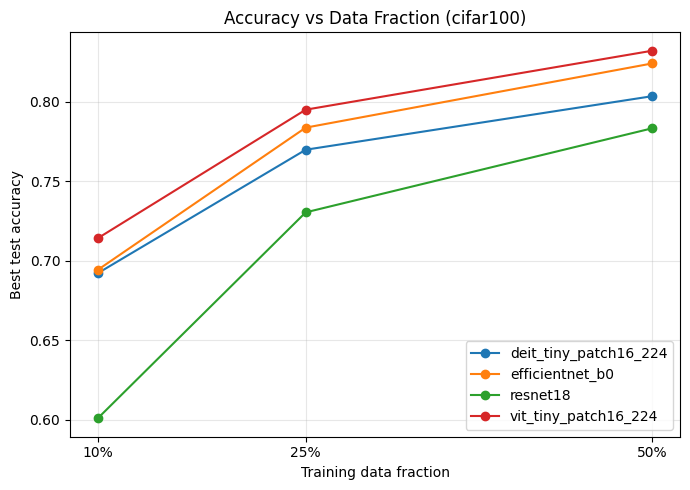

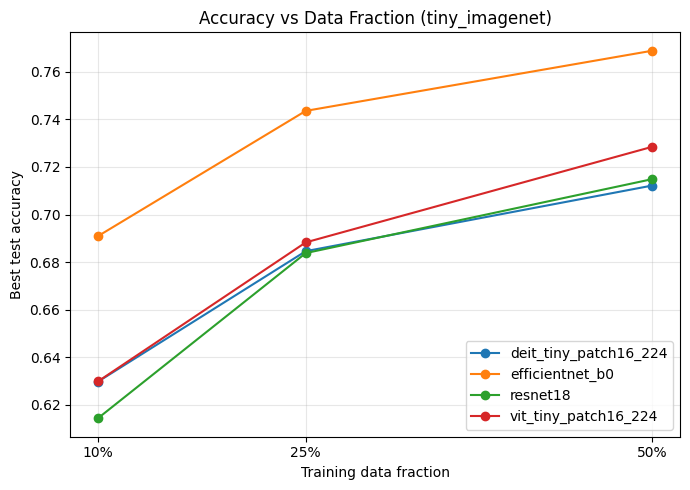

In [ ]:
import matplotlib.pyplot as plt

def plot_acc_vs_fraction(df, dataset):
    d = df[df["dataset"] == dataset].copy()

    plt.figure(figsize=(7,5))
    for m in sorted(d["model"].unique()):
        dm = d[d["model"] == m].sort_values("subset_frac")
        plt.plot(dm["subset_frac"], dm["best_test_acc"],
                 marker="o", label=m)

    plt.title(f"Accuracy vs Data Fraction ({dataset})")
    plt.xlabel("Training data fraction")
    plt.ylabel("Best test accuracy")
    plt.xticks([0.1, 0.25, 0.5], ["10%", "25%", "50%"])  # ⭐关键
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


plot_acc_vs_fraction(df, "cifar100")
plot_acc_vs_fraction(df, "tiny_imagenet")

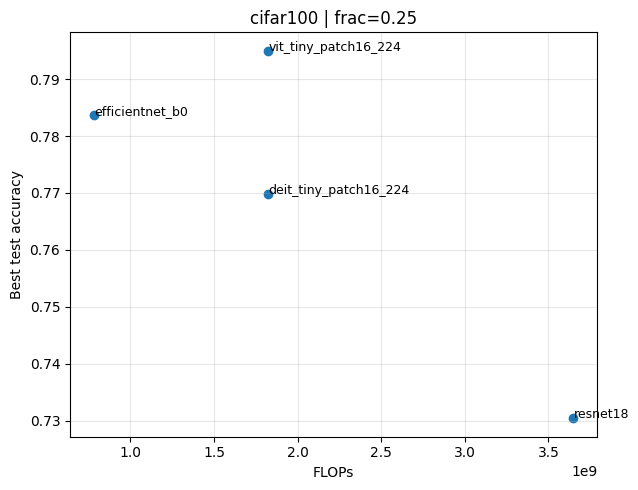

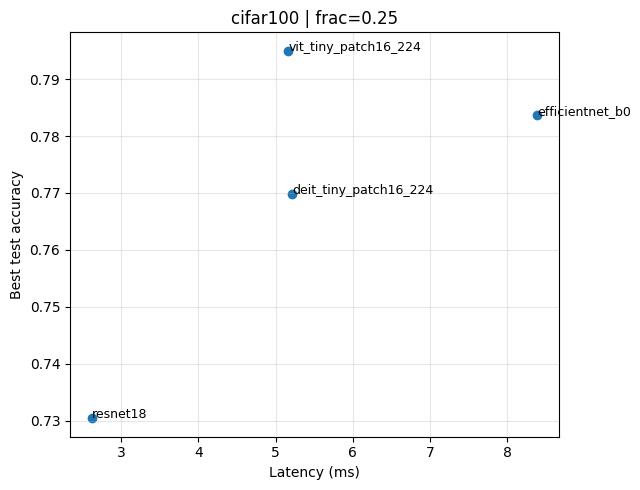

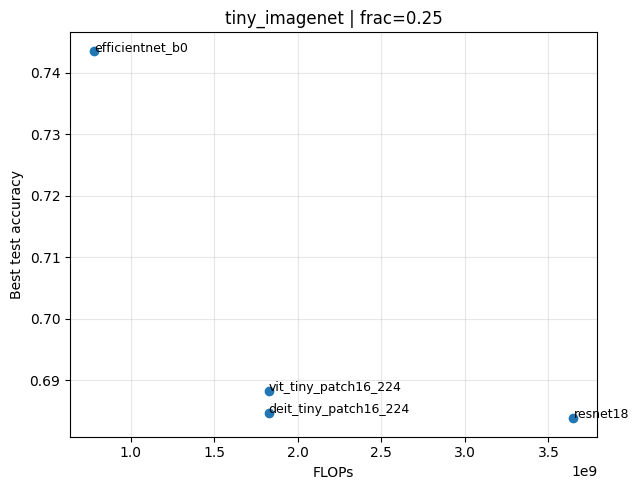

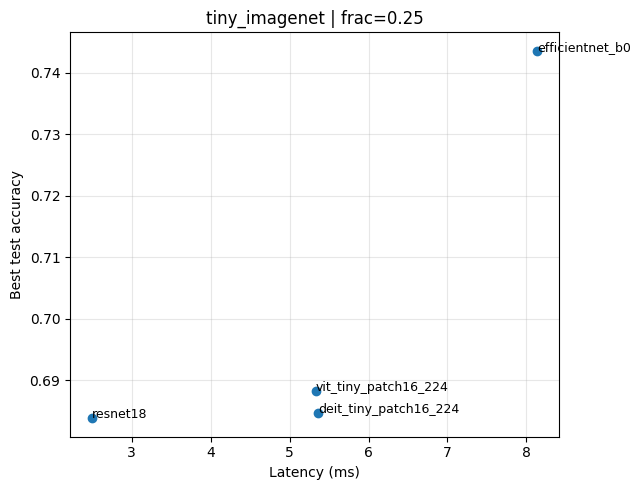

In [ ]:
def plot_tradeoff(df, dataset, frac, xcol, xlabel):
    d = df[(df["dataset"] == dataset) & (df["subset_frac"] == frac)]

    plt.figure(figsize=(6.5,5))
    plt.scatter(d[xcol], d["best_test_acc"])

    for _, r in d.iterrows():
        plt.annotate(r["model"],
                     (r[xcol], r["best_test_acc"]),
                     fontsize=9)

    plt.xlabel(xlabel)
    plt.ylabel("Best test accuracy")
    plt.title(f"{dataset} | frac={frac}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# 推荐只画 frac = 0.25（最有代表性）
plot_tradeoff(df, "cifar100", 0.25, "flops", "FLOPs")
plot_tradeoff(df, "cifar100", 0.25, "latency_ms", "Latency (ms)")
plot_tradeoff(df, "tiny_imagenet", 0.25, "flops", "FLOPs")
plot_tradeoff(df, "tiny_imagenet", 0.25, "latency_ms", "Latency (ms)")


In [ ]:
table_10 = (
    df[df["subset_frac"] == 0.1]
    [["dataset", "model", "best_test_acc", "params", "flops", "latency_ms"]]
    .sort_values(["dataset", "best_test_acc"], ascending=[True, False])
)

table_10


,dataset,model,best_test_acc,params,flops,latency_ms
2,cifar100,vit_tiny_patch16_224,0.7141,5543716,1.825427e+09,5.132184
1,cifar100,efficientnet_b0,0.6942,4135648,7.819111e+08,8.058763
3,cifar100,deit_tiny_patch16_224,0.6921,5543716,1.825427e+09,5.248046
0,cifar100,resnet18,0.6008,11227812,3.649704e+09,2.541258
13,tiny_imagenet,efficientnet_b0,0.6909,4263748,7.821673e+08,8.281944
14,tiny_imagenet,vit_tiny_patch16_224,0.6298,5563016,1.825466e+09,5.213549
15,tiny_imagenet,deit_tiny_patch16_224,0.6297,5563016,1.825466e+09,5.156000
12,tiny_imagenet,resnet18,0.6143,11279112,3.649807e+09,2.581856
